# Set Covering

In [6]:
from random import random, seed
from itertools import accumulate
import numpy as np
from tqdm.auto import tqdm
from icecream import ic
from matplotlib import pyplot as plt
import math

In [23]:
var_UNIVERSE_SIZE = [1000,10000]
var_NUM_SETS = [100, 1000]
var_DENSITY = [0.2,0.3]
MAX_STEPS = 1000
SETS = None
COSTS = None


In [24]:
def generate_sets_and_cots(universe_size, num_sets, density):
    global SETS, COSTS, rng, UNIVERSE_SIZE, NUM_SETS, DENSITY
    UNIVERSE_SIZE = universe_size
    NUM_SETS = num_sets
    DENSITY = density
    
    rng = np.random.Generator(np.random.PCG64([universe_size, num_sets, int(10_000 * density)]))
    SETS = rng.random((num_sets, universe_size)) < density
    for s in range(universe_size):
        if not np.any(SETS[:, s]):
            SETS[rng.integers(num_sets), s] = True
    COSTS = np.power(SETS.sum(axis=1), 1.1)


sistemare cosa delle iteraziona
sistemare simulated annealing 
mettere tabu search

*Helper function*

In [26]:
def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    return np.all(np.logical_or.reduce(SETS[solution]))

def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

def fitness(solution):
    """Returns the fitness of a solution"""
    return (valid(solution), -cost(solution)) 
def fitness_improved(solution):
    """Returns the fitness of a solution in terms of (# of covered items, -cost)"""
    return (np.sum(np.any(SETS[solution], axis=0)), -cost(solution))
def starting_point():
    """Returns a valid starting point"""
    solution = rng.random(NUM_SETS) < 1
    return solution
def starting_point_2():
    """Returns a valid starting point"""
    solution = rng.random(NUM_SETS) < 0.01
    return solution
def plotter(history):
    c_values = [c for v, c in history]
    plt.figure(figsize=(14, 8))
    plt.plot( range(len(c_values)), list(accumulate(c_values, max)),color="red",label="- Cost (Cumulative Max)")
    _ = plt.scatter(range(len(c_values)), c_values, marker=".", label="- Cost (Each Step)")
    plt.xlabel("Iteration")
    plt.ylabel("Fitness Value")
    plt.legend()
    plt.grid(True)
    plt.show()
def plotter2(history):
    s_values = [s for s, c in history]
    plt.figure(figsize=(14, 8))
    plt.plot( range(len(s_values)), list(accumulate(s_values, max)),color="red", label="# of Covered Items (Cumulative Max)")
    _ = plt.scatter(range(len(s_values)), s_values, marker=".", label="# of Covered Items (Each Step)")   
    plt.xlabel("Iteration")
    plt.ylabel("Fitness Value")
    plt.legend()
    plt.grid(True)
    plt.show() 

# First dumb solutions

In [27]:
# A dumb solution of "all" sets
for universe_size, num_sets, density in zip(UNIVERSE_SIZE, NUM_SETS, DENSITY):
    generate_sets_and_cots(universe_size, num_sets, density)
    solution = np.full(num_sets, True)
    print(f"({valid(solution)}, {cost(solution)})")

(True, 34399.36910141707)
(True, 6675545.539746648)


In [28]:
# A random solution with random 50% of the sets
for universe_size, num_sets, density in zip(var_UNIVERSE_SIZE, var_NUM_SETS, var_DENSITY):
    generate_sets_and_cots(universe_size, num_sets, density)
    solution = rng.random(num_sets) < .5
    print(f"({valid(solution)}, {cost(solution)})")

(True, 15343.390857790255)
(True, 3322961.8630263666)


# Hill Climbing solution Single-RM

In [29]:
def tweak1(solution):
    """Returns a new solution by flipping a random set"""
    new_solution = solution.copy()
    index= rng.integers(NUM_SETS)
    new_solution[index] = ~new_solution[index]
    return new_solution
    

In [30]:
def hill_climb(tweak, sp, f, plot):
    solution = sp()
    history = [f(solution)]
    for _ in range(MAX_STEPS):
        new_solution = tweak(solution)
        history.append(f(new_solution))
        if f(new_solution) > f(solution):
            solution = new_solution   
    plot(history)
    return solution


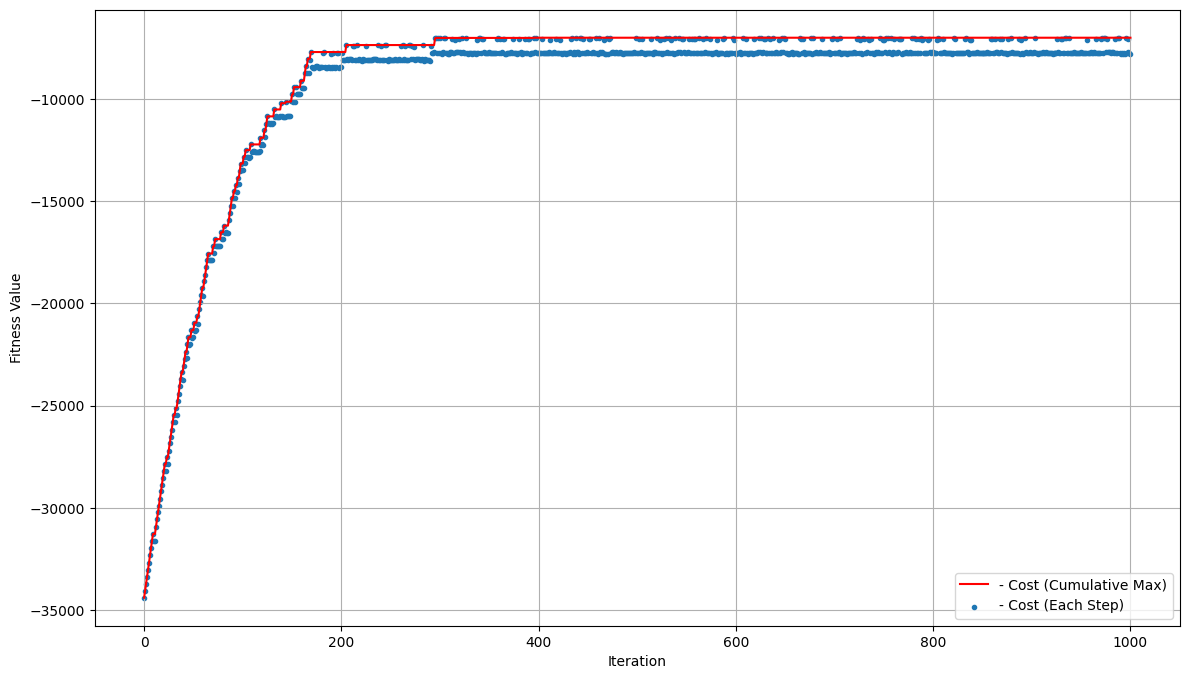

(True, 7396.781553001073)


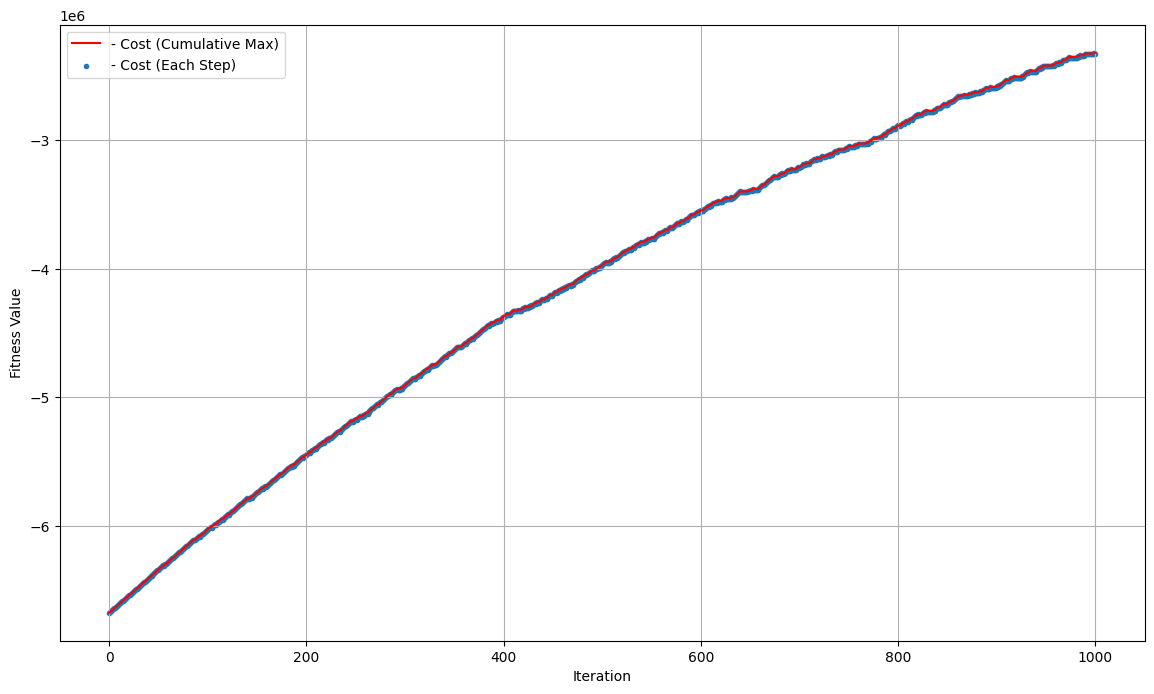

(True, 2319061.1199610876)


In [32]:
for universe_size, num_sets, density in zip(var_UNIVERSE_SIZE, var_NUM_SETS, var_DENSITY):
    generate_sets_and_cots(universe_size, num_sets, density)
    solution = hill_climb(tweak1, starting_point, fitness, plotter)
    print(f"({valid(solution)}, {cost(solution)})")


# Hill Climbing Multiple-RM

In [33]:
def tweak2(solution):
    new_solution = solution.copy()
    index = None
    while index is None or np.random.random() < 0.4:
        index= rng.integers(NUM_SETS)
        new_solution[index] = ~new_solution[index]
    return new_solution

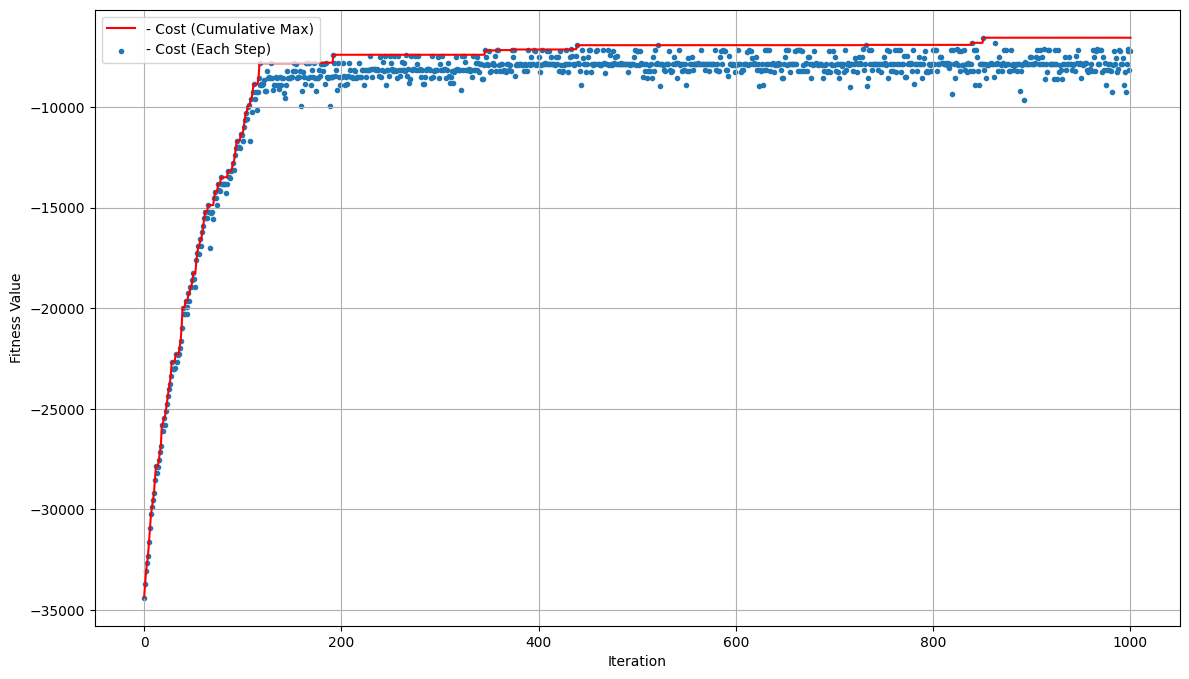

(True, 7508.037681406941)


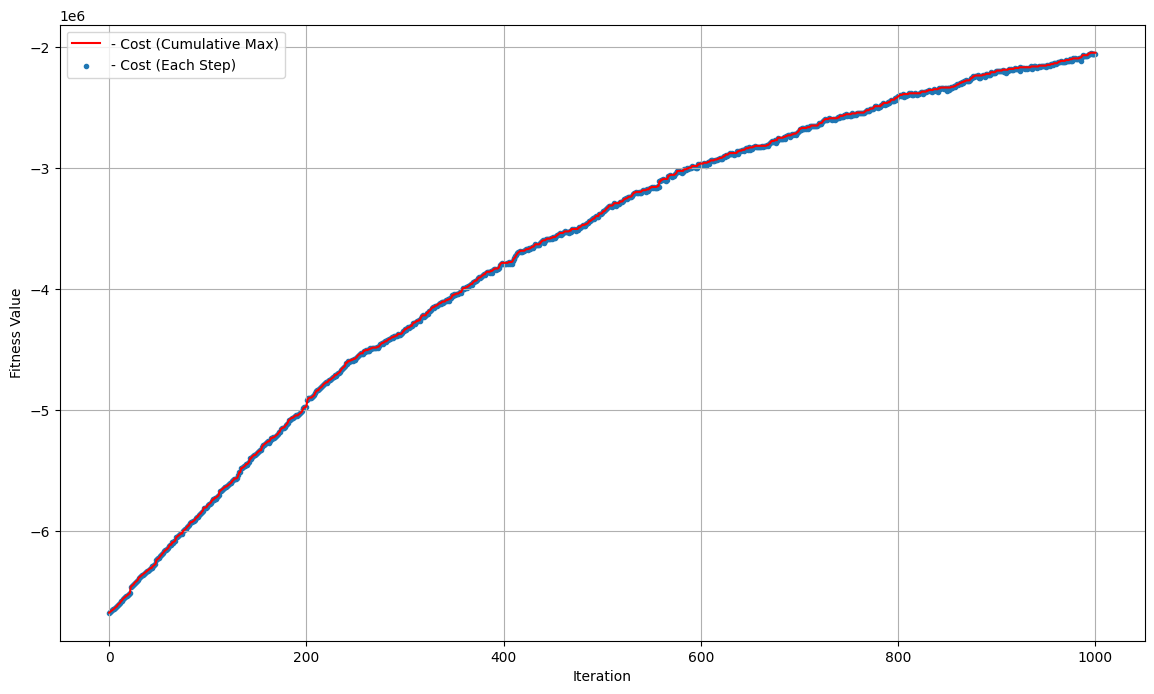

(True, 2045805.3144975756)


In [34]:
for universe_size, num_sets, density in zip(var_UNIVERSE_SIZE, var_NUM_SETS, var_DENSITY):
    generate_sets_and_cots(universe_size, num_sets, density)
    solution = hill_climb(tweak2, starting_point, fitness, plotter)
    print(f"({valid(solution)}, {cost(solution)})")


# Hill Climbing  Multiple-RMHC (2° Version)

In [35]:
def tweak2_improved(solution):
    new_solution = solution.copy()

    activate_set = rng.random() < 0.5
    
    if activate_set:
        candidates = np.where(new_solution == False)[0]
        if len(candidates) > 0:
            index = rng.choice(candidates)
            new_solution[index] = True
    else:
        
        candidates = np.where(new_solution == True)[0]
        if len(candidates) > 0:
            index = rng.choice(candidates)
            new_solution[index] = False
    
    
    while np.random.random() < 0.5:
        index = rng.integers(NUM_SETS)
        new_solution[index] = ~new_solution[index]
    
    return new_solution


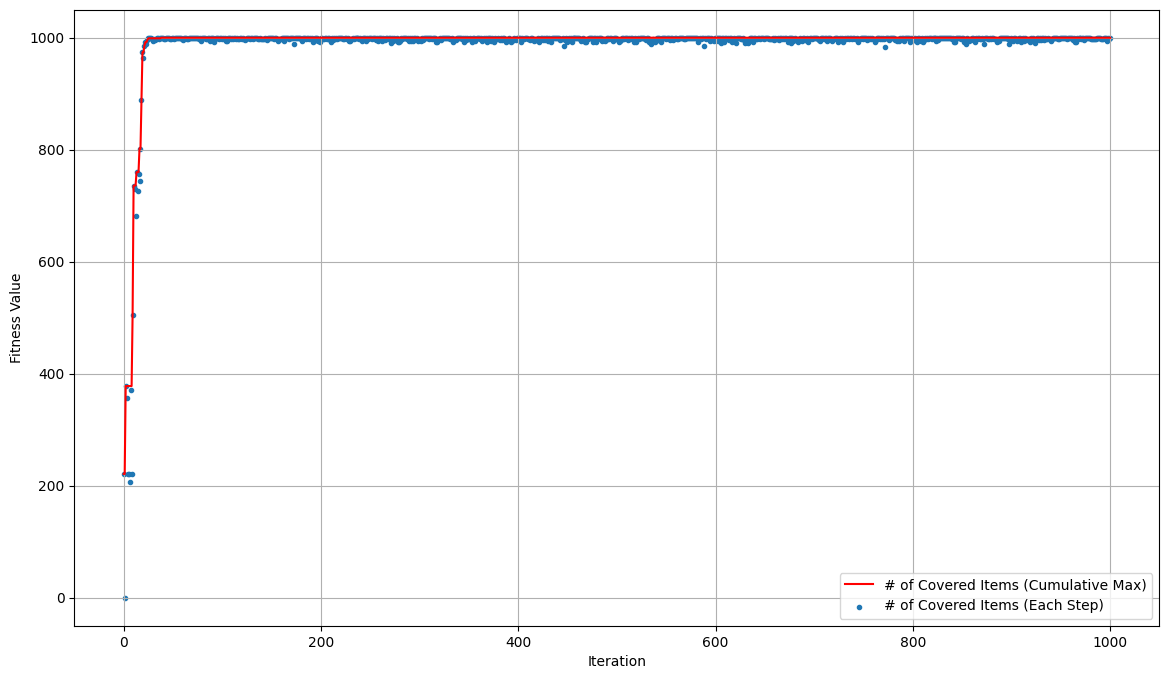

(True, 6799.633734632218)


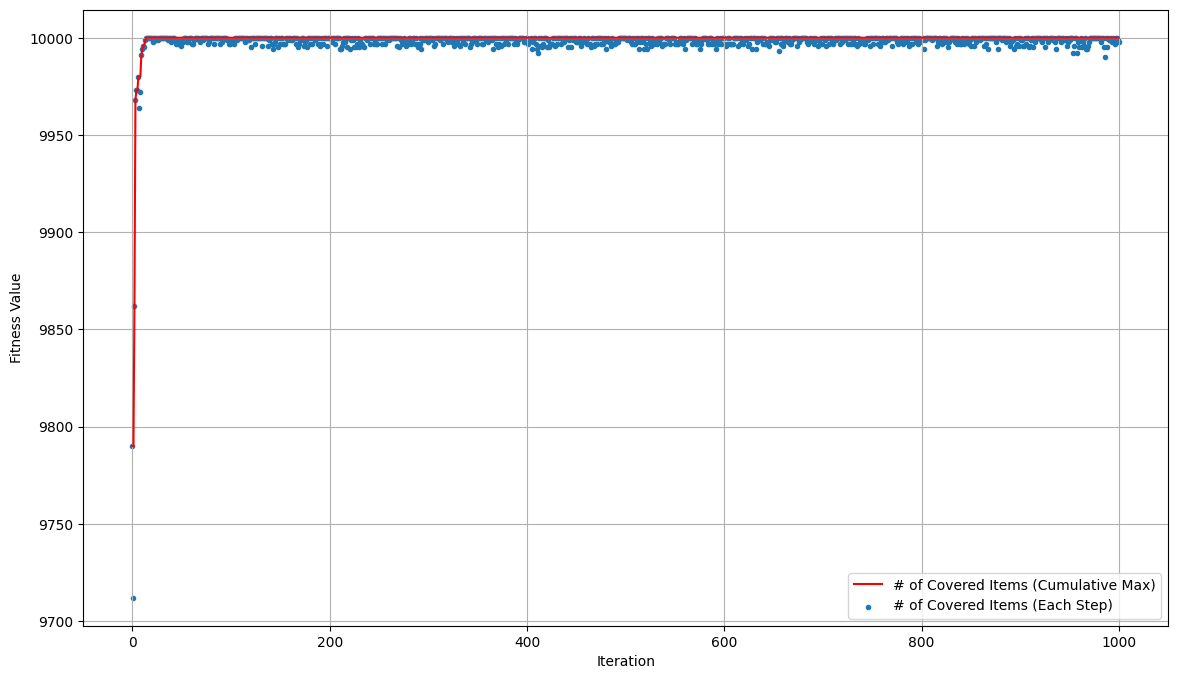

(True, 132385.44215449344)


In [36]:
for universe_size, num_sets, density in zip(var_UNIVERSE_SIZE, var_NUM_SETS, var_DENSITY):
    generate_sets_and_cots(universe_size, num_sets, density)
    solution = hill_climb(tweak2_improved, starting_point_2, fitness_improved, plotter2)
    print(f"({valid(solution)}, {cost(solution)})")


# Steepest step and restart

In [37]:
NUM_RESTARTS = 3
STEEPEST_STEP_CANDIDATES = 5
TRUE_MAX_STEPS = MAX_STEPS // STEEPEST_STEP_CANDIDATES
def steepest_step():
    history = list()
    for i in tqdm(range(NUM_RESTARTS), position=0):
        solution = starting_point_2()
        history.append(fitness_improved(solution))
        for _ in tqdm (range(TRUE_MAX_STEPS//NUM_RESTARTS), position=1, desc=f'step {i+1}'):
            candidates = [tweak2_improved(solution) for _ in range(STEEPEST_STEP_CANDIDATES)]
            candidates_fitness = list()

            for candidate in candidates:
                candidates_fitness.append(fitness_improved(candidate))
                history.append(fitness_improved(candidate))
            idx = candidates_fitness.index(max(candidates_fitness))   
            new_solution = candidates[idx]
            new_fitness = candidates_fitness[idx]
            if new_fitness > fitness_improved(solution):
                solution = new_solution

    plotter2(history)
    return solution


  0%|          | 0/3 [00:00<?, ?it/s]

step 1:   0%|          | 0/66 [00:00<?, ?it/s]

step 2:   0%|          | 0/66 [00:00<?, ?it/s]

step 3:   0%|          | 0/66 [00:00<?, ?it/s]

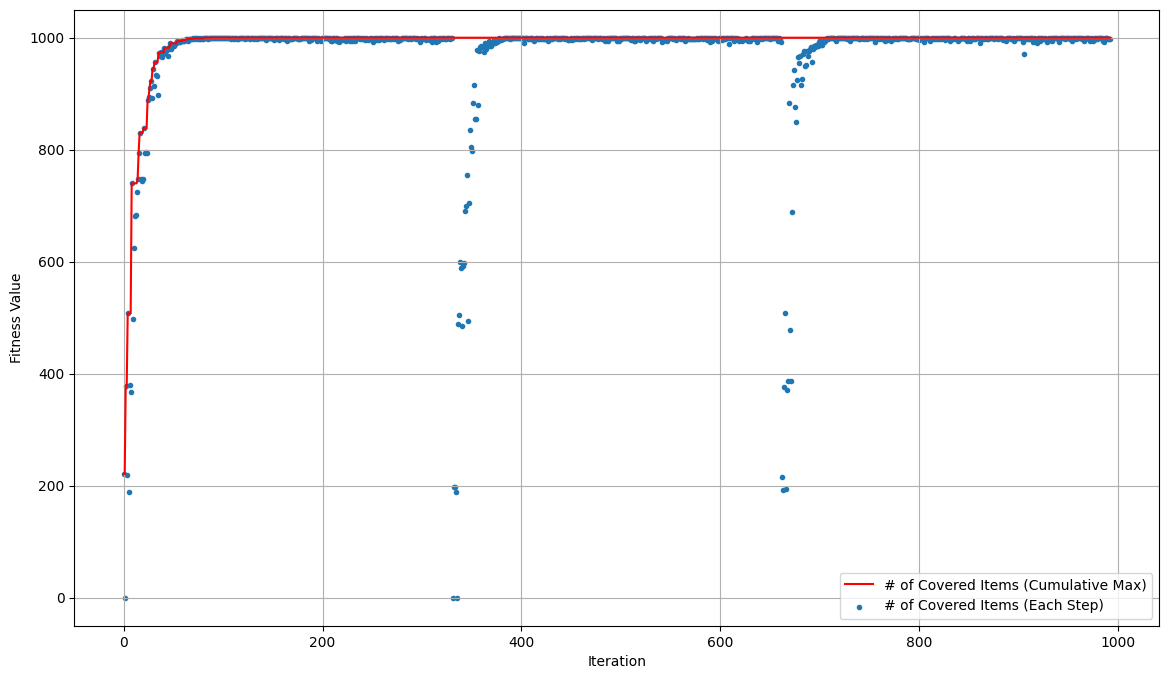

(True, 7138.210247874143)


  0%|          | 0/3 [00:00<?, ?it/s]

step 1:   0%|          | 0/66 [00:00<?, ?it/s]

step 2:   0%|          | 0/66 [00:00<?, ?it/s]

step 3:   0%|          | 0/66 [00:00<?, ?it/s]

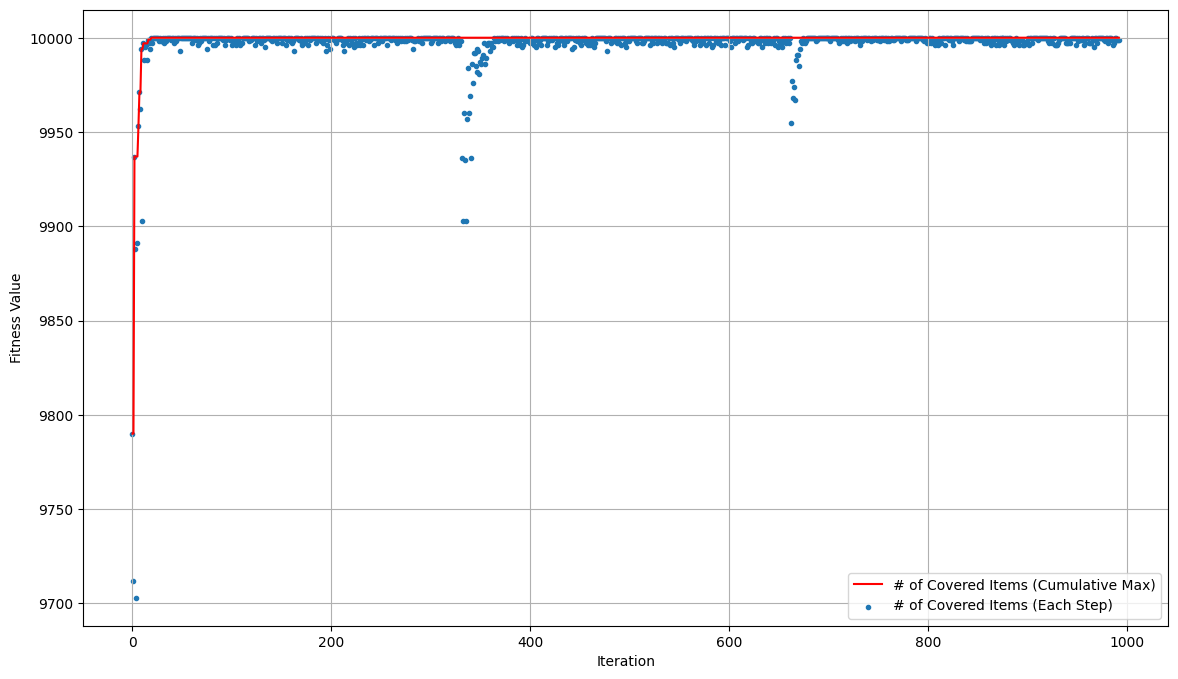

(True, 139717.5485726029)


In [38]:
for universe_size, num_sets, density in zip(var_UNIVERSE_SIZE, var_NUM_SETS, var_DENSITY):
    generate_sets_and_cots(universe_size, num_sets, density)
    solution = steepest_step()
    print(f"({valid(solution)}, {cost(solution)})")

# Simulated Annealing

In [40]:
INITIAL_TEMPERATURE = 1000 
COOLING_RATE = 0.995 
def simulated_annealing(tweak, sp, f, plot, penalty_weight=1e6):
   
    S = sp()  
    Best = S.copy() 
    current_fitness = f(S)
    current_value, current_cost = current_fitness

    temperature = INITIAL_TEMPERATURE
    current_p = penalty_weight * (not valid(S))
    current_cost -= current_p
    history = [(current_value, current_cost)]
    
    while temperature > 1e-10:  
        R = tweak(S.copy()) 
        new_fitness = f(R) 
        new_value, new_cost = new_fitness  
        new_p = penalty_weight * (not valid(R))
        new_cost -= new_p
        if (new_cost > current_cost  ) or rng.random() < math.exp((new_cost - current_cost) / temperature):
            S = R
            current_value, current_cost = new_value, new_cost 
            history.append((current_value, current_cost))  
            
            
            if new_cost > f(Best)[1] and valid(R): 
                Best = S.copy() 

        
        temperature *= COOLING_RATE
   
    plot(history)
    return Best 


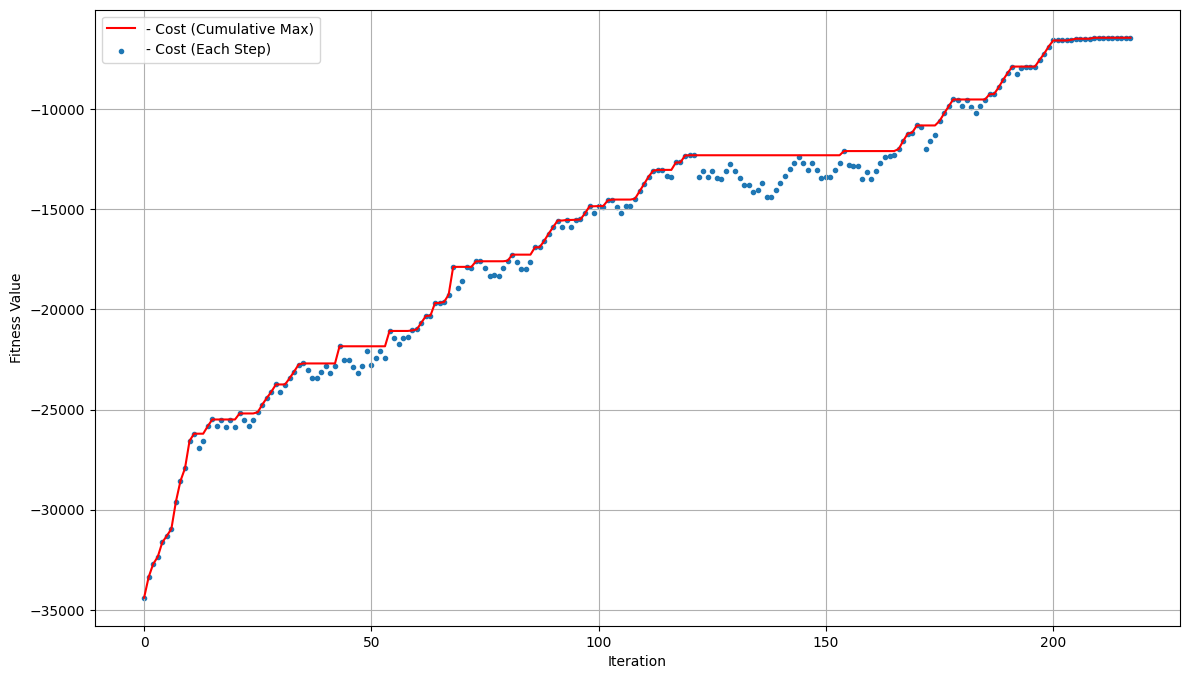

(True, 6431.8528774086635)


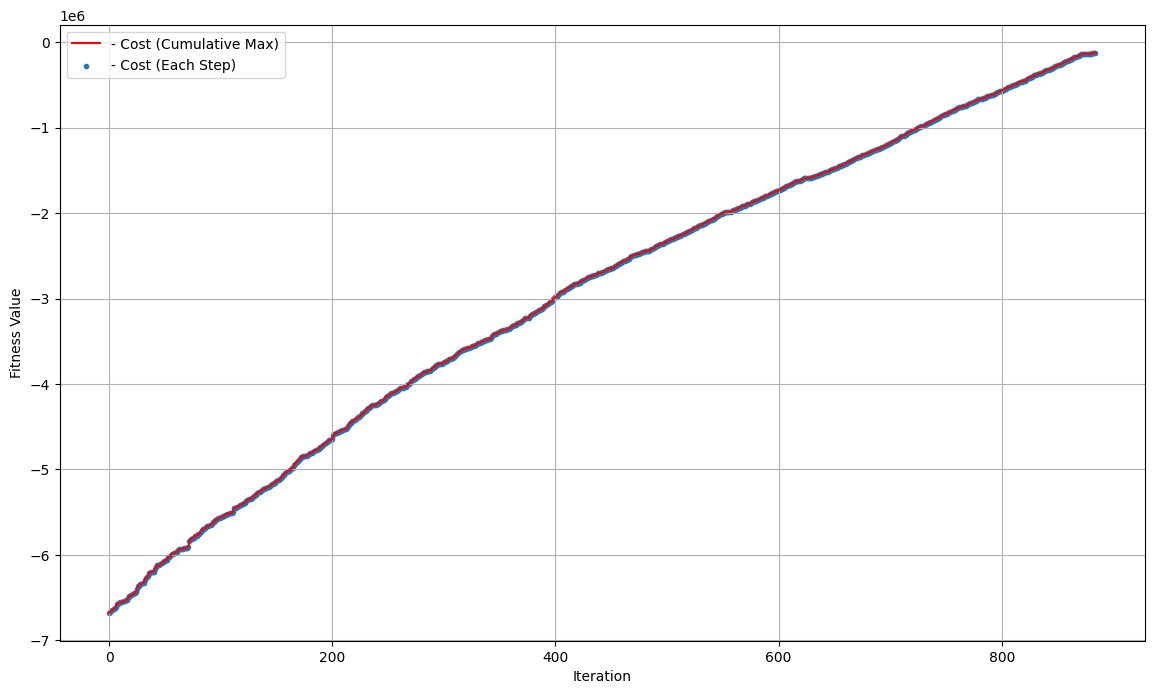

(True, 124967.47950197518)


In [41]:
for universe_size, num_sets, density in zip(var_UNIVERSE_SIZE, var_NUM_SETS, var_DENSITY):
    generate_sets_and_cots(universe_size, num_sets, density)
    solution = simulated_annealing(tweak2_improved, starting_point, fitness, plotter)
    print(f"({valid(solution)}, {cost(solution)})")